# Data loading: Carga de datos en la base de datos.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import numpy    as np
import pandas   as pd
import logging

import util     as ut
import database as db
from domain_context import DomainContext

### Setup

In [4]:
DATASET_PATH = '../../datasets/amazon-books'
DB_CONFIG = {
  'host'     : 'localhost',
  'user'     : 'root',
  'password' : '1234'
}
API_HOST = 'http://localhost:8000'

In [11]:
database                = db.Database(DB_CONFIG)
items_repository        = db.ItemRepository(database)
interactions_repository = db.InteractionRepository(database)

In [6]:
ctx = DomainContext(host=API_HOST)

In [7]:
items        = pd.read_json(f'{DATASET_PATH}/db_items.json')
interactions = pd.read_json(f'{DATASET_PATH}/db_interactions.json')

### Pre-procesamiento y filtrado de items mas populares

In [10]:
items = items \
    .pipe(ut.clean_html_format, 'description') \
    .pipe(ut.distinct_by, ['id', 'name'])

2022-12-23 19:59:45,971 :: INFO :: root :: Repeated rows by ['id', 'name'] -> Count: 294, Percent: 0.07%


In [9]:
repeaded_items = items \
    .groupby(['id', 'name']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['count'], ascending=False)

repeaded_items = repeaded_items[repeaded_items['count'] > 1]

repeaded_items.head(3)

,id,name,count
385489,385504,1913. The Defiant Swan Song,2
384907,384922,The life of Christ,2
384935,384950,The United States in World War I; the story of...,2


In [11]:
def compute_item_popuparity(df):
    return interactions \
        .groupby(['item_id'],as_index=False) \
        .agg({'rating': 'mean', 'user_id': 'count'}) \
        .rename(columns={'rating': 'rating_mean', 'user_id': 'interactions'}) \
        .sort_values(['interactions'], ascending=False) \
        .pipe(ut.min_max_scale_column, 'interactions', 'interactions_norm') \
        .pipe(ut.apply_fn_to_column, 'popularity', lambda df: df['rating_mean'] * df['interactions_norm']) \
        .pipe(ut.min_max_scale_column, 'popularity')

In [12]:
item_popuparity = compute_item_popuparity(interactions)
item_popuparity.head(5)

,item_id,rating_mean,interactions,interactions_norm,popularity
1170,1171,4.127072,181,1.000000,0.888228
215478,215479,4.646409,181,1.000000,1.000000
217936,217937,4.655556,180,0.994444,0.996402
214451,214452,4.648045,179,0.988889,0.989237
215081,215082,4.648045,179,0.988889,0.989237


In [13]:
item_popuparity.shape

(406269, 5)

(36, 181, (1029, 5))

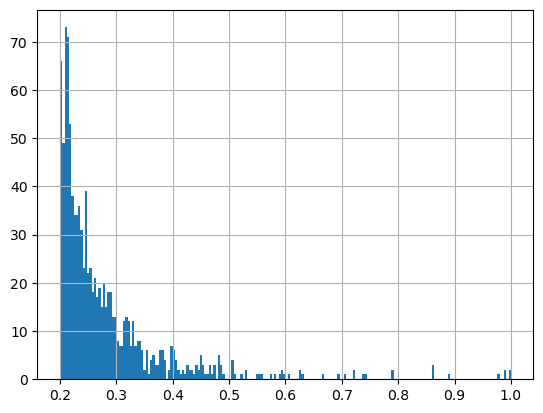

In [18]:
filtered_item_popuparity = item_popuparity[item_popuparity['popularity'] > 0.2]
filtered_item_popuparity.popularity.hist(bins=200)

filtered_item_popuparity.interactions.min(), filtered_item_popuparity.interactions.max(), filtered_item_popuparity.shape

In [19]:
item_ids = filtered_item_popuparity.item_id.unique()
item_ids.shape

(1029,)

In [20]:
filtered_items        = items[items.id.isin(item_ids)]
filtered_interactions = interactions[interactions.item_id.isin(item_ids)]

In [21]:
filtered_items.shape, filtered_interactions.shape

((1029, 4), (55369, 3))

### Insertar items e interacciones en la base de datos

In [ ]:
database.reset()

In [22]:
items_repository.save_all(filtered_items)

In [23]:
interactions_repository.save_all(filtered_interactions)

In [1]:
# result = database.execute("SELECT ... FROM ...", select=True)
# pd.DataFrame(result, columns=[...])